In [148]:
%load_ext autoreload
%autoreload 2
from sound_field import SoundField,divide_to_time_windows,divide_to_subbands
from signal_info import signal_info
from optimizer import optimizer
from optimizer_v2 import optimizer_v2
from DoA_est import DoA_via_bands
import utils
import numpy as np
import math
import time
import torch
import gc
import os
from collections import defaultdict,Counter
import matplotlib.pyplot as plt

LEBEDEV = 'lebedev'
POINTS_162 = '162_points'
SQP_OPT_METHOD = "SQP"
GD_DEEP_OPT_METHOD = "GD_Deep"
GD_OPT_METHOD = "GD_lagrange_multi" #GD_Deep GD_lagrange_multi
SLS_OPT_METHOD = "SLS"
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Device Name:", torch.cuda.get_device_name(DEVICE))
else:
    DEVICE = torch.device("cpu")
    print("Device Name: CPU")
torch.set_grad_enabled(False)
torch.cuda.empty_cache()  # Free up unused memory on GPU
gc.collect()  # Clean up unused memory on CPU


# Notes:
# 1) Do we really need such a high # of iter? Maybe some windows/freqs we can stop early?
# 2) Diff # of iter in localization and sound field creation?
# 3) Add mask creatiion to class? (add mask detauils to sound_field)
# 4) Sparse Attention


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device Name: NVIDIA GeForce RTX 4080 SUPER


7820

In [149]:
def mem_status():
    gc.collect() 
    gpu_tensors = [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor) and obj.device.type == 'cuda']
    print(f"GPU Tensors: {len(gpu_tensors)}")
    for tensor in gpu_tensors:
        num_elements = tensor.numel()
        element_size = tensor.element_size()
        memory_size_bytes = num_elements * element_size / 1e6
        print(f"Tensor on device: {tensor.device} : {memory_size_bytes}  MB")

In [150]:
mem_status()

GPU Tensors: 10
Tensor on device: cuda:0 : 0.0  MB
Tensor on device: cuda:0 : 0.0  MB
Tensor on device: cuda:0 : 0.002592  MB
Tensor on device: cuda:0 : 0.0  MB
Tensor on device: cuda:0 : 0.00486  MB
Tensor on device: cuda:0 : 0.00192  MB
Tensor on device: cuda:0 : 0.00192  MB
Tensor on device: cuda:0 : 0.07776  MB
Tensor on device: cuda:0 : 0.00192  MB
Tensor on device: cuda:0 : 0.00192  MB


C:\Users\amitmils\AppData\Local\Temp\ipykernel_38720\3564447253.py:3: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  gpu_tensors = [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor) and obj.device.type == 'cuda']


In [151]:
signals = [
    signal_info(
        signal_path=r"data/sound_files/male_speech.wav",
        th=90,
        ph=90,
        in_rad=False,
    ),
    signal_info(
        signal_path=r"data/sound_files/female_speech.wav",
        th=90,
        ph=45,
        in_rad=False,
    ),
]

### Encode Sound Field

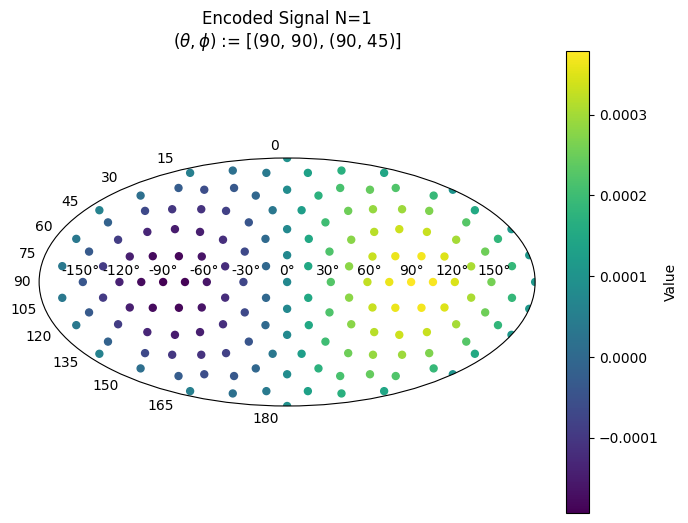

In [152]:
sound_field = SoundField(DEVICE)
input_order = 1
upscale_order = 3
anm_t = sound_field.create(
    signals=signals,
    order=input_order,
    debug=True,
    grid_type=POINTS_162,
)
Y_p = utils.create_sh_matrix(input_order, zen=sound_field.P_th, azi=sound_field.P_ph)

### Divide to Subbands

In [153]:
down_sample = 1
sound_field.num_bins = num_bins = 45
sound_field.anm_t_subbands = divide_to_subbands(
    anm_t, num_bins=num_bins, downsample=down_sample
)
print(sound_field.anm_t_subbands.shape)
print(f"{sound_field.anm_t_subbands.is_cuda=}")

c:\Users\amitmils\Documents\Repo\AmbisonicUpscaling\sound_field.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anm_t_subbands[:, :, coeff] = torch.tensor(erb_bank.subbands.T).clone().detach()


torch.Size([45, 136370, 4])
sound_field.anm_t_subbands.is_cuda=False


### Divide to Windows

In [155]:
sound_field.window_length = window_length = 1024
max_num_windows = 30
sound_field.anm_t_windowed = divide_to_time_windows(
    sound_field.anm_t_subbands,
    window_length=window_length,
    max_num_windows=int(max_num_windows),
)
sound_field.num_windows = sound_field.anm_t_windowed.shape[0]
print(sound_field.anm_t_windowed.shape)
print(f"{sound_field.anm_t_windowed.is_cuda=}")

torch.Size([30, 45, 1024, 4])
sound_field.anm_t_windowed.is_cuda=False


### Create Mask


In [156]:
mask_type = None # "cheat" None , 'algo'

if mask_type is None:
    mask = None
    sound_field.has_mask = False
else:
    sound_field.has_mask = True
    if mask_type == "cheat":
        target_th = torch.tensor([math.radians(coo[0]) for coo in sound_field.sources_coords])
        target_ph = torch.tensor([math.radians(coo[1]) for coo in sound_field.sources_coords])
        mask = torch.any(torch.sqrt((sound_field.P_th[...,None] - target_th)**2 + (sound_field.P_ph[...,None] - target_ph)**2) < math.radians(10),dim=1)
    elif mask_type == "algo":
        pass
    dummy = torch.zeros_like(mask)
    dummy[mask] = 1
    utils.plot_on_2D(
        azi=sound_field.P_ph,
        zen=sound_field.P_th,
        values=dummy,
        title=f"Spatial Mask\n$(\\theta,\\phi)$ := {[tuple((round(th),round(phi))) for (th,phi) in sound_field.sources_coords]}",
    )


### Find Sparse Dict 


In [157]:
if True:
    opt = optimizer(Y_p, alpha=1., method=GD_OPT_METHOD,device=DEVICE)
    opt.P_th = sound_field.P_th
    opt.P_ph = sound_field.P_ph
    print(f"Method : {opt.method}")
    start = time.time()
    with torch.no_grad():
        s_dict_subbands, s_windowed, s_dict = sound_field.get_sparse_dict_v2(sound_field.anm_t_windowed,opt,mask,iter = 1e5,multi_processing=False,save=True) #single processing progress bar doesnt work
    print(f"Time: {time.time()-start}")
    real_anmt = sound_field.anm_t_windowed.sum(dim=1).squeeze().reshape(-1,4)
    print(f"{real_anmt.shape=}")
    est_anmt = (Y_p.cpu() @ s_dict.cpu()).t()
    print(f"{est_anmt.shape=}")

Method : GD_lagrange_multi


100%|██████████| 100000/100000 [00:17<00:00, 5638.48it/s]


Failed to plot loss
Finished Optimization...Unmixing
Finished Unmixing...
Sound field saved to data/output\sound_field_1_order_30_win_45_bin_162_points_NOmask_25Y_01M_21F_13H_33m.pt
Time: 19.581844329833984
real_anmt.shape=torch.Size([30720, 4])
est_anmt.shape=torch.Size([30720, 4])


#### Plot Loss Per Freq

In [33]:
loss_per_freq = opt.reconstruction_loss.squeeze()
from_iter = int(1e5-1000)
to_iter = int(1e5)
plt.figure()
for i in range(loss_per_freq.shape[1]):
    plt.plot(range(from_iter,to_iter),loss_per_freq[from_iter:to_iter].cpu())
plt.title("Reconstruction Loss Per Freq")
plt.xlabel("Iteration")
plt.ylabel("Loss")


IndexError: tuple index out of range

<Figure size 640x480 with 0 Axes>

### Loss Per Time Stamp

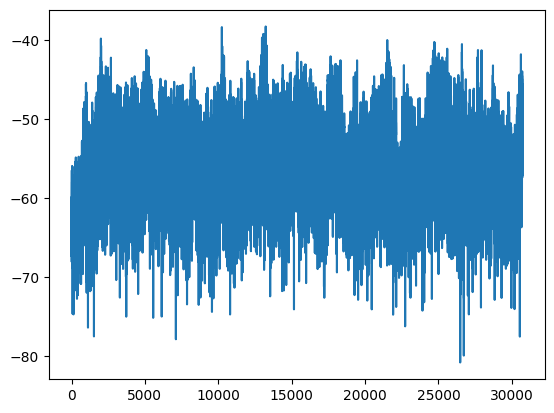

In [158]:
loss = 10*torch.log10(torch.norm(real_anmt- est_anmt,dim=1)**2)
plt.figure()
plt.plot(loss.cpu())

-55.32764434814453
Signal 0 : 0.0123291015625 | Phi = 90.0 | Theta = 90.0
Signal 1 : 0.00108265969902277 | Phi = 45.0 | Theta = 90.0
tensor(-47.8813)


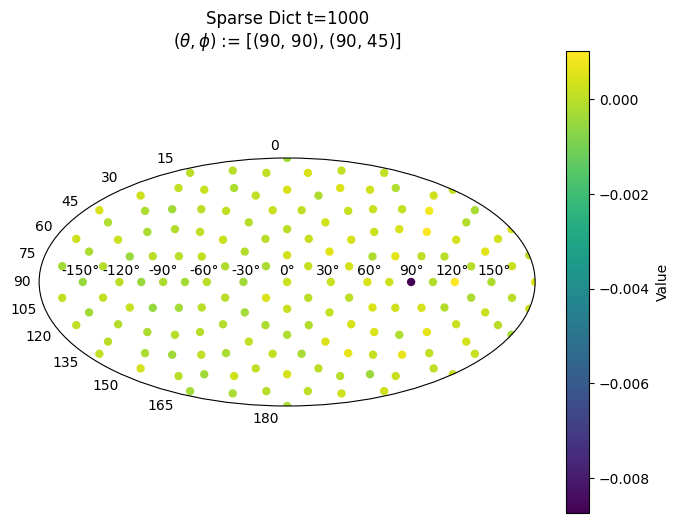

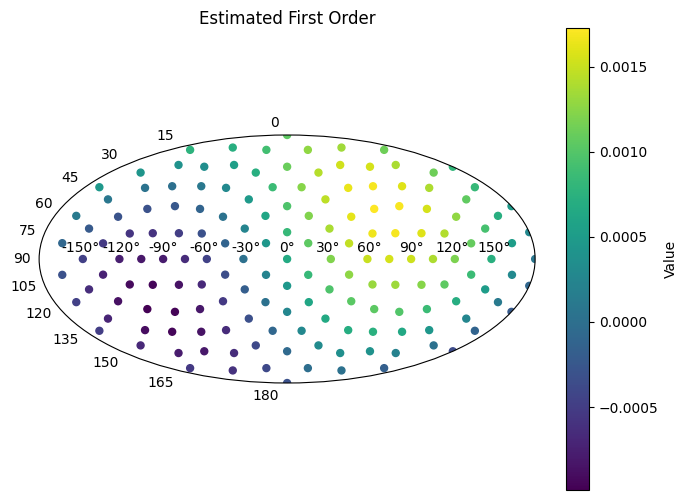

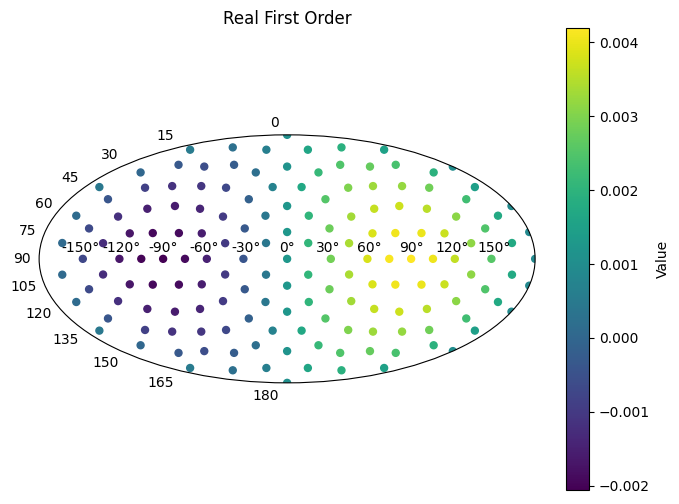

In [159]:
print(f"{torch.mean(loss)}")

time_index = 1000

for i,sig in enumerate(sound_field.signals):
    print(f"Signal {i} : {sig.signal.squeeze()[time_index]} | Phi = {math.degrees(sig.ph)} | Theta = {math.degrees(sig.th)}")
sound_field.plot_sparse_dict(sound_field.s_dict,time_index)
print(10*torch.log10(torch.norm(real_anmt[time_index,:] - est_anmt[time_index,:],p=2)**2))
utils.plot_on_2D(
            azi=sound_field.P_ph,
            zen=sound_field.P_th,
            values=torch.conj(Y_p).cpu().t() @ est_anmt[time_index,:],
            title=f"Estimated First Order",
)
utils.plot_on_2D(
            azi=sound_field.P_ph,
            zen=sound_field.P_th,
            values=torch.conj(Y_p).cpu().t() @ anm_t[time_index,:],
            title=f"Real First Order",
)


In [169]:
sound_field.play_sparse_sound_field(phi=45,theta=90,radius=10)

torch.Size([162, 30720])
## Playing Directions ##
Theta = 45.33929672174684, Phi = 99.24300322695115
Theta = 45.33929672174684, Phi = 80.75699677304884


In [30]:
Y_p = utils.create_sh_matrix(
    input_order, zen=sound_field.P_th, azi=sound_field.P_ph
).to(DEVICE)

Y_p_tag = utils.create_sh_matrix(
    upscale_order, zen=sound_field.P_th, azi=sound_field.P_ph
).to(
    DEVICE
)  # upscaling matrix
opt_v2 = optimizer_v2(Y_p=Y_p, alpha=0.01, num_iters=1e2, device=DEVICE)
s_dict_subbands = opt_v2.forward(sound_field.anm_t_windowed, mask, upscale_order)


100%|██████████| 100/100 [00:00<00:00, 1388.19it/s]


In [31]:
s_dict_windowed = torch.sum(s_dict_subbands, axis=1)
s_dict = s_dict_windowed.permute(1, 0, 2).reshape(
    sound_field.num_grid_points, sound_field.window_length * sound_field.num_windows)
sound_field.est_anm_upscaled = torch.matmul(Y_p_tag, s_dict)
sound_field.est_anm_upscaled.shape

torch.Size([16, 2048])

In [65]:
torch.conj(Y_p).cpu().shape

torch.Size([4, 162])

In [2]:
sound_field = torch.load("data/output\sound_field_1_order_30_win_45_bin_2702_points_NOmask_24Y_11M_21F_21H_12m.pt")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\amitmils\AppData\Local\Temp\ipykernel_26636\229298355.py:1: SyntaxWarning: invalid escape sequence '\s'
  sound_field = torch.load("data/output\sound_field_1_order_30_win_45_bin_2702_points_NOmask_24Y_11M_21F_21H_12m.pt")
C:\Users\amitmils\AppData\Local\Temp\ipykernel_26636\229298355.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly all

## Direction 

In [ ]:
doa_estimator = DoA_via_bands(sound_field, DEVICE)

1/30
2/30


: 

In [ ]:
doa_estimator.normalized_abs_sound_field[10,40].shape


torch.Size([30, 2702, 1024])

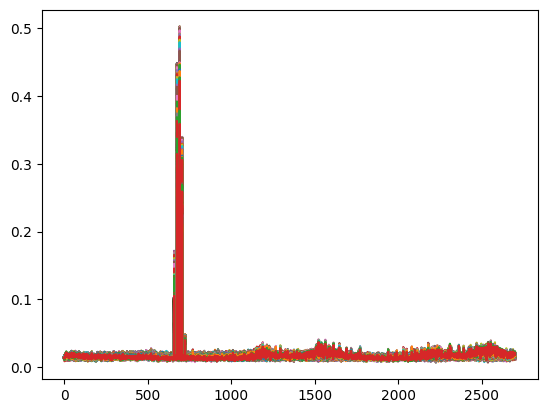

In [ ]:
doa_estimator.normalized_abs_sound_field.shape
tmp = doa_estimator.normalized_abs_sound_field.sum(dim=1)
for i in range(doa_estimator.normalized_abs_sound_field.shape[1]):
    plt.figure()
    plt.plot(doa_estimator.normalized_abs_sound_field[10,i])
    plt.title(f"Bin : {i}")
plt.show()

In [12]:
est = doa_estimator._get_window_candidates()

In [14]:
est[0]

[]

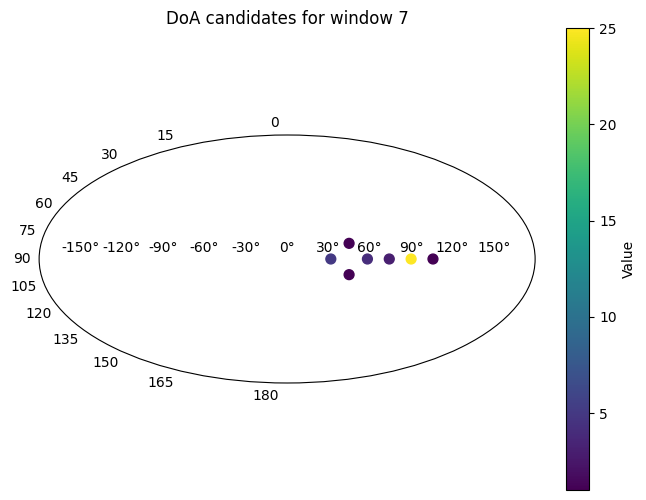

In [254]:
doa_estimator.plot_window_candidates(est,window=7)

In [102]:
def show_candidates(window_dir_candidates,window_num = None):
    if window_num is None:
        for window_num in range(len(window_dir_candidates)):
            th = window_dir_candidates[window_num][:,0].numpy()
            phi = window_dir_candidates[window_num][:,1].numpy()
            prob = window_dir_candidates[window_num][:,2].numpy()
            if len(th) == 0:
                print(f"Window {window_num} No candidates")
                continue
            plt.figure()
            plt.title(f"Window {window_num} DoA candidates\n({th@prob:.2f},{phi@prob:.2f})")
            plt.xlim(-180,180)
            plt.ylim(0,180)
            plt.scatter(th,phi,c=prob,cmap='viridis')
            plt.colorbar()
    else:
        plt.figure()
        plt.title(f"Window {window_num} DoA candidates\n({th@prob:.2f},{phi@prob:.2f})")
        plt.xlim(-180,180)
        plt.ylim(0,180)
        plt.scatter(th,phi,c=prob,cmap='viridis')
        plt.colorbar()

In [49]:
sound_field.play_sparse_sound_field(theta=90,phi=0,radius = 20)

torch.Size([162, 30720])
## Playing Directions ##
Theta = 0.0, Phi = 90.0
Theta = -15.450437086325833, Phi = 80.65029645742543
Theta = 0.0, Phi = 74.1412627942695
Theta = 0.0, Phi = 105.8587372057305
Theta = -15.450437086325833, Phi = 99.34970354257459
Theta = 15.450437086325833, Phi = 80.65029645742543
Theta = 15.450437086325833, Phi = 99.34970354257459
